Bloco 1: Importações (Bibliotecas Necessárias)

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Importações do Scikit-learn
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Ignorar warnings futuros para manter a saída limpa
import warnings
warnings.filterwarnings('ignore')

print("Bibliotecas carregadas com sucesso.")

Bibliotecas carregadas com sucesso.


Bloco 2: Carregamento dos Dados de Origem

In [2]:
# Carregando o DataFrame de Vendas (do NB 03 - transacional completo)
caminho_sales = '../data/redis/sales.parquet'
df_sales = pd.read_parquet(caminho_sales)

# Carregando o DataFrame 'customers' (do NB 04 - o arquivo mestre que será atualizado)
caminho_customers = '../data/redis/customers.parquet'
df_customers = pd.read_parquet(caminho_customers)

# Carregando a feature store RFM (do NB 03 - usada para o merge final)
caminho_rfm_completo = '../data/curated/rfm_features.parquet'
df_rfm_completo = pd.read_parquet(caminho_rfm_completo)

print(f"Dados de vendas carregados: {len(df_sales)} transações.")
print(f"Dados de clientes carregados: {len(df_customers)} clientes únicos.")

Dados de vendas carregados: 50000 transações.
Dados de clientes carregados: 25642 clientes únicos.


Bloco 3: Definição do Corte Temporal e Gabarito (30 dias)

In [3]:
# Encontrando a última data de compra no dataset
ultima_data = df_sales['data_venda'].max()
print(f"A última compra registrada foi em: {ultima_data.date()}")

# Definindo nossa data de corte (90 dias antes do final)
data_corte = ultima_data - pd.Timedelta(days=90)
print(f"Nossa data de corte para a análise será: {data_corte.date()}")

# Separando os dados em treino (passado) e teste (futuro/gabarito)
df_treino = df_sales[df_sales['data_venda'] <= data_corte].copy()
df_futuro = df_sales[df_sales['data_venda'] > data_corte]
print(f"Temos {len(df_treino)} registros de treino (passado) e {len(df_futuro)} registros no 'futuro' (gabarito).")

# 1. Gabarito para 30 dias:
data_corte_30d = data_corte + pd.Timedelta(days=30)
df_futuro_30d = df_futuro[df_futuro['data_venda'] <= data_corte_30d]
clientes_que_compraram_30d = df_futuro_30d['id_cliente'].unique()
print(f"Encontramos {len(clientes_que_compraram_30d)} clientes únicos que compraram nos primeiros 30 dias do período futuro (Gabarito 30d).")

A última compra registrada foi em: 2024-04-01
Nossa data de corte para a análise será: 2024-01-02
Temos 47342 registros de treino (passado) e 2658 registros no 'futuro' (gabarito).
Encontramos 850 clientes únicos que compraram nos primeiros 30 dias do período futuro (Gabarito 30d).


Bloco 4: Criação do Gabarito (7 dias)

In [4]:
# 2. Gabarito para 7 dias:
data_corte_7d = data_corte + pd.Timedelta(days=7)
df_futuro_7d = df_futuro[df_futuro['data_venda'] <= data_corte_7d]
clientes_que_compraram_7d = df_futuro_7d['id_cliente'].unique()
print(f"Encontramos {len(clientes_que_compraram_7d)} clientes únicos que compraram nos primeiros 7 dias do período futuro (Gabarito 7d).")

Encontramos 262 clientes únicos que compraram nos primeiros 7 dias do período futuro (Gabarito 7d).


Bloco 5: Engenharia de Features Transacionais e Encoder Global

In [5]:
print("Iniciando engenharia de features transacionais (em df_treino)...")

# Criando features comportamentais (como 1/0 para calcular médias)
df_treino['viaja_sozinho'] = (df_treino['total_tickets_quantity_success'] == 1).astype(int)
df_treino['compra_fds'] = (df_treino['data_venda'].dt.dayofweek >= 5).astype(int)
df_treino['taxa_ida_e_volta'] = (df_treino['place_origin_return'] != '0').astype(int)
print("Features comportamentais (1/0) criadas.")

print("Criando LabelEncoder global para Viações...")
le = LabelEncoder()
# Treinamos o encoder em TODAS as viações possíveis (usando df_sales, não apenas df_treino)
all_viacao_hashes = df_sales['fk_departure_ota_bus_company'].fillna('0').unique()
le.fit(all_viacao_hashes)
print(f"LabelEncoder global treinado com {len(le.classes_)} classes únicas.")

Iniciando engenharia de features transacionais (em df_treino)...
Features comportamentais (1/0) criadas.
Criando LabelEncoder global para Viações...
LabelEncoder global treinado com 259 classes únicas.


Bloco 6: Criação da Feature Store Agregada (Histórica)

In [6]:
print("Iniciando criação da Feature Store Agregada (Histórica)...")

snapshot_date_treino = data_corte + pd.Timedelta(days=1)

# Definição das agregações
agg_base = {
    'data_venda': [lambda date: (snapshot_date_treino - date.max()).days, 'min', 'max'], # Recência e datas para Tenure
    'id_cliente': 'count', # Frequência
    'valor_venda': 'sum', # Valor Monetário
    'produto': 'nunique', # Rotas Distintas
    'fk_departure_ota_bus_company': lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan # Viação Favorita (Hash)
}
agg_comportamento = {
    'viaja_sozinho': 'mean',  # pct_viagens_sozinho
    'compra_fds': 'mean',       # pct_compras_fds
    'taxa_ida_e_volta': 'mean' # taxa_ida_e_volta
}

# Executando a agregação
df_features_treino = df_treino.groupby('id_cliente').agg({**agg_base, **agg_comportamento})

# Renomeando colunas multi-índice
df_features_treino.columns = [
    'Recencia', 'Data_Primeira_Compra', 'Data_Ultima_Compra', 'Frequencia', 'ValorMonetario',
    'Rotas_Distintas', 'Viacao_Favorita_Hash', 'pct_viagens_sozinho', 'pct_compras_fds', 'taxa_ida_e_volta'
]

# Criando as features derivadas (Ticket Médio e Tenure)
df_features_treino['Ticket_Medio'] = df_features_treino['ValorMonetario'] / df_features_treino['Frequencia']
df_features_treino['Tenure'] = (snapshot_date_treino - df_features_treino['Data_Primeira_Compra']).dt.days
df_features_treino = df_features_treino.drop(columns=['Data_Primeira_Compra', 'Data_Ultima_Compra'])
df_features_treino.fillna(0, inplace=True)

# Codificando a Viação Favorita (usando o encoder 'le' do Bloco 5)
df_features_treino['Viacao_Favorita_ID'] = le.transform(df_features_treino['Viacao_Favorita_Hash'])
df_features_treino = df_features_treino.drop(columns=['Viacao_Favorita_Hash'])

print("Feature Store Histórica criada com sucesso com 11 features.")
display(df_features_treino.head())

Iniciando criação da Feature Store Agregada (Histórica)...
Feature Store Histórica criada com sucesso com 11 features.


,Recencia,Frequencia,ValorMonetario,Rotas_Distintas,pct_viagens_sozinho,pct_compras_fds,taxa_ida_e_volta,Ticket_Medio,Tenure,Viacao_Favorita_ID
id_cliente,,,,,,,,,,
0001018716456b2b34ca7a31f9b597974be6e1c9f6122a1bba5bb9c267a9e7fe,169,1,193.61,1,1.0,0.0,0.0,193.61,169,87
0004d0000beb6c47a5ae74d13af1d0c7e862101147492532fc32d80211558660,1412,1,81.82,1,1.0,0.0,0.0,81.82,1412,36
00066779acf4b4cae18112860bbb556f0a0b609f5cbdfcefd5ebb574f7e7d600,1280,1,68.44,1,1.0,0.0,0.0,68.44,1280,36
0007d4c7a554f2aa722aa7840d953395da4c019c36c51dda73c7678d635683c9,1829,1,467.28,1,0.0,0.0,0.0,467.28,1829,242
000b40069834aaf5757373f9aac1e92968ccbcfff3838ccac21ab4a8eceb0df8,752,2,52.70,2,1.0,1.0,0.0,26.35,837,229


Bloco 7: Criação do Dataset Final de Treino (Features + Labels)

In [7]:
# Criando as duas variáveis-alvo (target)
df_features_treino['comprou_em_30d'] = df_features_treino.index.isin(clientes_que_compraram_30d).astype(int)
df_features_treino['comprou_em_7d'] = df_features_treino.index.isin(clientes_que_compraram_7d).astype(int)

# Dataset final para modelagem
df_modelo = df_features_treino.copy()

print("Dataset de modelo final (features + labels) criado.")
print(f"Distribuição 30d (Treino):\n{df_modelo['comprou_em_30d'].value_counts(normalize=True)}")
print(f"\nDistribuição 7d (Treino):\n{df_modelo['comprou_em_7d'].value_counts(normalize=True)}")

Dataset de modelo final (features + labels) criado.
Distribuição 30d (Treino):
comprou_em_30d
0    0.983884
1    0.016116
Name: proportion, dtype: float64

Distribuição 7d (Treino):
comprou_em_7d
0    0.99501
1    0.00499
Name: proportion, dtype: float64


Bloco 8: Otimização e Avaliação (Modelo 30 dias)

--- Iniciando Otimização de Hiperparâmetros (RandomizedSearch) para 30d ---
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:41] WARNING: /Users/runner/work/xgboost/xgboost/src/lea

Melhores parâmetros encontrados para 30d: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}

--- Avaliação do Modelo OTIMIZADO (30 dias) no conjunto de Teste ---
              precision    recall  f1-score   support

           0       0.99      0.81      0.89      4811
           1       0.05      0.61      0.09        79

    accuracy                           0.81      4890
   macro avg       0.52      0.71      0.49      4890
weighted avg       0.98      0.81      0.88      4890

AUC-ROC Score (30 dias Otimizado): 0.7692


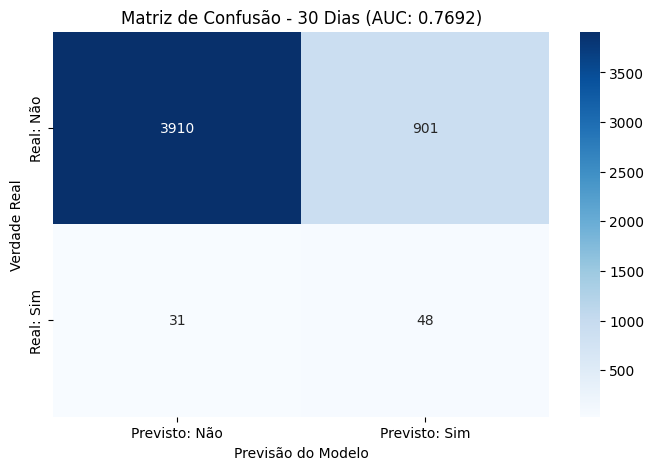


Importância das Features (Modelo 30d):


,Importancia
Recencia,0.323967
Frequencia,0.157938
ValorMonetario,0.080829
Ticket_Medio,0.079722
Tenure,0.074380
pct_compras_fds,0.073555
Rotas_Distintas,0.071657
Viacao_Favorita_ID,0.058174
pct_viagens_sozinho,0.047054
taxa_ida_e_volta,0.032724


In [8]:
# Definindo nossa lista final de 10 features para o modelo
FEATURES = [
    'Recencia', 'Frequencia', 'ValorMonetario', 'Rotas_Distintas', 
    'Viacao_Favorita_ID', 'pct_viagens_sozinho', 'pct_compras_fds', 
    'taxa_ida_e_volta', 'Ticket_Medio', 'Tenure'
]

X = df_modelo[FEATURES]
y_30d = df_modelo['comprou_em_30d']

# 1. Dividir em Treino/Teste para a OTIMIZAÇÃO
X_train, X_test, y_train, y_test = train_test_split(X, y_30d, test_size=0.2, random_state=42, stratify=y_30d)

# 2. Calcular o scale_pos_weight (para o desbalanceamento)
weight_30d = sum(y_train == 0) / sum(y_train == 1)

# 3. Definir a Grade de Parâmetros
param_dist = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'gamma': [0, 0.1, 0.2]
}

# 4. Configurar e Rodar o RandomizedSearchCV
print("--- Iniciando Otimização de Hiperparâmetros (RandomizedSearch) para 30d ---")
xgb_base = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight_30d, eval_metric='logloss', use_label_encoder=False)

random_search_30d = RandomizedSearchCV(
    xgb_base, param_distributions=param_dist, 
    n_iter=25, cv=3, scoring='roc_auc', 
    random_state=42, n_jobs=-1, verbose=1
)

random_search_30d.fit(X_train, y_train)

# 5. Avaliar o MELHOR modelo
best_model_30d = random_search_30d.best_estimator_
print(f"Melhores parâmetros encontrados para 30d: {random_search_30d.best_params_}")

print("\n--- Avaliação do Modelo OTIMIZADO (30 dias) no conjunto de Teste ---")
y_pred_30d = best_model_30d.predict(X_test)
y_prob_30d = best_model_30d.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_30d))
auc_30d = roc_auc_score(y_test, y_prob_30d)
print(f"AUC-ROC Score (30 dias Otimizado): {auc_30d:.4f}")

# --- CÓDIGO DO HEATMAP ADICIONADO AQUI ---
# 6. Matriz de Confusão Visual
cm = confusion_matrix(y_test, y_pred_30d)
plt.figure(figsize=(8, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto: Não', 'Previsto: Sim'], 
            yticklabels=['Real: Não', 'Real: Sim'])
plt.title(f'Matriz de Confusão - 30 Dias (AUC: {auc_30d:.4f})')
plt.ylabel('Verdade Real')
plt.xlabel('Previsão do Modelo')
plt.show()
# --- FIM DO CÓDIGO ADICIONADO ---

# 7. Plotar Importância das Features
feat_imp = pd.DataFrame(best_model_30d.feature_importances_, index=FEATURES, columns=['Importancia']).sort_values(by='Importancia', ascending=False)
print("\nImportância das Features (Modelo 30d):")
display(feat_imp)

Bloco 9: Otimização e Avaliação (Modelo 7 dias)


--- Iniciando Otimização de Hiperparâmetros para 7d ---
Fitting 3 folds for each of 25 candidates, totalling 75 fits


/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/jeankeslernunes/Desktop/fiap_sulistas/.venv/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [18:13:51] WARNING: /Users/runner/work/xgboost/xgboost/src/lea

Melhores parâmetros encontrados para 7d: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}

--- Avaliação do Modelo OTIMIZADO (7 dias) no conjunto de Teste ---
              precision    recall  f1-score   support

           0       1.00      0.85      0.92      4866
           1       0.02      0.62      0.04        24

    accuracy                           0.85      4890
   macro avg       0.51      0.74      0.48      4890
weighted avg       0.99      0.85      0.91      4890

AUC-ROC Score (7 dias Otimizado): 0.8161


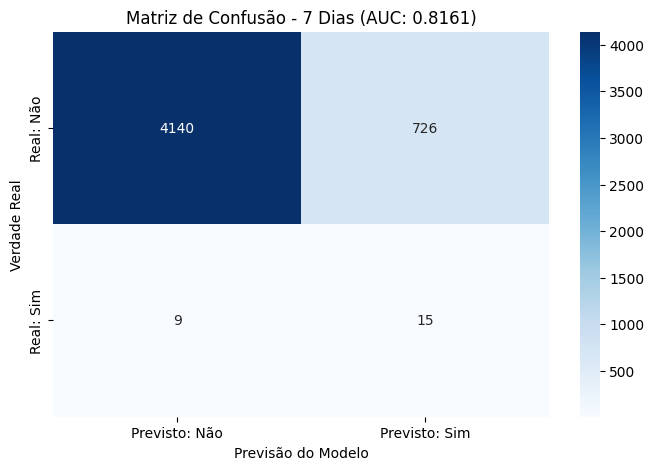

In [9]:
print("\n--- Iniciando Otimização de Hiperparâmetros para 7d ---")

y_7d = df_modelo['comprou_em_7d']
X_train, X_test, y_train, y_test = train_test_split(X, y_7d, test_size=0.2, random_state=42, stratify=y_7d)

# Calcular o peso (muito maior aqui)
weight_7d = sum(y_train == 0) / sum(y_train == 1)

xgb_base_7d = xgb.XGBClassifier(random_state=42, scale_pos_weight=weight_7d, eval_metric='logloss', use_label_encoder=False)

random_search_7d = RandomizedSearchCV(
    xgb_base_7d, param_distributions=param_dist,
    n_iter=25, cv=3, scoring='roc_auc',
    random_state=42, n_jobs=-1, verbose=1
)

random_search_7d.fit(X_train, y_train)

# Capturar e Avaliar o MELHOR modelo 7d
best_model_7d = random_search_7d.best_estimator_
print(f"Melhores parâmetros encontrados para 7d: {random_search_7d.best_params_}")

print("\n--- Avaliação do Modelo OTIMIZADO (7 dias) no conjunto de Teste ---")
y_pred_7d = best_model_7d.predict(X_test)
y_prob_7d = best_model_7d.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_7d))
auc_7d = roc_auc_score(y_test, y_prob_7d)
print(f"AUC-ROC Score (7 dias Otimizado): {auc_7d:.4f}")

# --- CÓDIGO DO HEATMAP ADICIONADO AQUI ---
# Matriz de Confusão Visual para 7 dias
cm_7d = confusion_matrix(y_test, y_pred_7d)
plt.figure(figsize=(8, 5))
sns.heatmap(cm_7d, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Previsto: Não', 'Previsto: Sim'], 
            yticklabels=['Real: Não', 'Real: Sim'])
plt.title(f'Matriz de Confusão - 7 Dias (AUC: {auc_7d:.4f})')
plt.ylabel('Verdade Real')
plt.xlabel('Previsão do Modelo')
plt.show()
# --- FIM DO CÓDIGO ADICIONADO ---

Bloco 10: Treino FINAL e Atualização do customers.parquet (Output)

In [10]:
print("--- Iniciando etapa final: Treinando modelos com 100% dos dados históricos ---")

# --- ETAPA 1: Preparar os dados FINAIS de predição (Feature Store Completa) ---
print("Recriando features agregadas para a base de clientes COMPLETA...")
df_sales['viaja_sozinho'] = (df_sales['total_tickets_quantity_success'] == 1).astype(int)
df_sales['compra_fds'] = (df_sales['data_venda'].dt.dayofweek >= 5).astype(int)
df_sales['taxa_ida_e_volta'] = (df_sales['place_origin_return'] != '0').astype(int)
snapshot_date_final = df_sales['data_venda'].max() + pd.Timedelta(days=1)

# Agregações
df_features_finais = df_sales.groupby('id_cliente').agg({**agg_base, **agg_comportamento})

# Renomeia colunas
df_features_finais.columns = [
    'Recencia_calc', # <-- ESTE É O NOME QUE FALTAVA
    'Data_Primeira_Compra', 'Data_Ultima_Compra', 'Frequencia_calc', 'ValorMonetario_calc',
    'Rotas_Distintas', 'Viacao_Favorita_Hash', 'pct_viagens_sozinho', 'pct_compras_fds', 'taxa_ida_e_volta'
] # Nota: nomes alterados para evitar colisão com merge

# Merge com o RFM original (do NB 03/04) para obter o RFM 'correto' que o KMeans usou
df_features_finais = df_features_finais.merge(df_rfm_completo[['Recencia', 'ValorMonetario', 'Frequencia']], left_index=True, right_index=True)

# Cria features derivadas usando as colunas corretas
df_features_finais['Ticket_Medio'] = df_features_finais['ValorMonetario'] / df_features_finais['Frequencia']
df_features_finais['Tenure'] = (snapshot_date_final - df_features_finais['Data_Primeira_Compra']).dt.days
df_features_finais['Viacao_Favorita_ID'] = le.transform(df_features_finais['Viacao_Favorita_Hash'])
df_features_finais.fillna(0, inplace=True)

# Garante que o DataFrame final para predição tenha as 10 features na ordem correta
X_para_prever_final = df_features_finais[FEATURES]

# --- ETAPA 2: Treinar os Modelos FINAIS (nos melhores params) com 100% dos dados históricos ---
print("Treinando modelo FINAL de 30d com melhores params em TODOS os dados históricos...")
model_FINAL_30d = random_search_30d.best_estimator_
model_FINAL_30d.fit(df_modelo[FEATURES], df_modelo['comprou_em_30d'])

print("Treinando modelo FINAL de 7d com melhores params em TODOS os dados históricos...")
model_FINAL_7d = random_search_7d.best_estimator_
model_FINAL_7d.fit(df_modelo[FEATURES], df_modelo['comprou_em_7d'])
print("Modelos finais treinados!")

# --- ETAPA 3: Gerar Predições Finais e Salvar ---
print("Gerando probabilidades finais para todos os clientes...")
probabilidades_30d = model_FINAL_30d.predict_proba(X_para_prever_final)[:, 1]
probabilidades_7d = model_FINAL_7d.predict_proba(X_para_prever_final)[:, 1]

# Criar um DF temporário com os novos scores
df_novos_scores = pd.DataFrame({
    'id_cliente': X_para_prever_final.index,
    'prob_compra_7d_novo': np.round(probabilidades_7d, 2),
    'prob_compra_30d_novo': np.round(probabilidades_30d, 2)
})

# Atualizar o arquivo df_customers (carregado no Bloco 2)
df_customers_atualizado = df_customers.drop(columns=['prob_compra_7d', 'prob_compra_30d'], errors='ignore')
df_customers_atualizado = df_customers_atualizado.merge(df_novos_scores, on='id_cliente', how='left')

# Renomear colunas para o padrão final do app
df_customers_atualizado = df_customers_atualizado.rename(columns={
    'prob_compra_7d_novo': 'prob_compra_7d',
    'prob_compra_30d_novo': 'prob_compra_30d'
})

# Garantir ordem correta das colunas
colunas_originais = [col for col in df_customers.columns if col not in ['prob_compra_7d', 'prob_compra_30d']]
colunas_finais_ordenadas = colunas_originais + ['prob_compra_7d', 'prob_compra_30d']
df_customers_atualizado = df_customers_atualizado[colunas_finais_ordenadas]

# Salvar o arquivo mestre ATUALIZADO
df_customers_atualizado.to_parquet(caminho_customers, index=False)

print(f"\nSUCESSO! Arquivo '{caminho_customers}' foi atualizado com as novas predições otimizadas.")
display(df_customers_atualizado[['nome_cliente', 'segmento', 'prob_compra_7d', 'prob_compra_30d']].head())


--- Iniciando etapa final: Treinando modelos com 100% dos dados históricos ---
Recriando features agregadas para a base de clientes COMPLETA...
Treinando modelo FINAL de 30d com melhores params em TODOS os dados históricos...
Treinando modelo FINAL de 7d com melhores params em TODOS os dados históricos...
Modelos finais treinados!
Gerando probabilidades finais para todos os clientes...

SUCESSO! Arquivo '../data/redis/customers.parquet' foi atualizado com as novas predições otimizadas.


,nome_cliente,segmento,prob_compra_7d,prob_compra_30d
0,Sarah Martins,Em Risco,0.70,0.52
1,Luiz Fernando Teixeira,Fiéis,0.08,0.13
2,Raul Leão,Fiéis,0.12,0.19
3,Thiago da Mota,Fiéis,0.08,0.10
4,Antony Leão,Em Risco,0.06,0.26
